In [176]:
import cv2
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
%matplotlib inline
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
print(os.listdir(r'C:\Users\Personal\Desktop\cats&dogs'))

['test1', 'train']


## Data Preparation

We can see that images in training are in different sizes.   

Size of cat.0 = 374*500  
Size of cat.1 = 280*300  
  
For the model we will need to resize them in way that all of them have the same size.

(374, 500, 3)

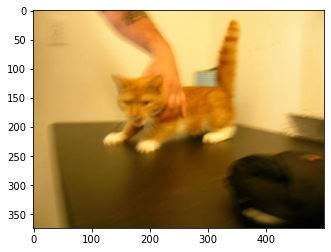

In [52]:
image1 = load_img(r'C:\Users\Personal\Desktop\cats&dogs\train\cat.0.jpg')
plt.imshow(image1)
img_arr1 = cv2.imread(r'C:\Users\Personal\Desktop\cats&dogs\train\cat.0.jpg')
img_arr1.shape

(280, 300, 3)

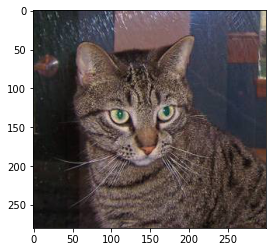

In [53]:
image2 = load_img(r'C:\Users\Personal\Desktop\cats&dogs\train\cat.1.jpg')
plt.imshow(image2)
img_arr2 = cv2.imread(r'C:\Users\Personal\Desktop\cats&dogs\train\cat.1.jpg')
img_arr2.shape

### Add labels to the images

In [65]:
filenames = os.listdir(r'C:\Users\Personal\Desktop\cats&dogs\train')
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'cat':
        categories.append(0)
    elif category == 'dog':
        categories.append(1)

df = pd.DataFrame({'filename' : filenames,
                    'category' : categories})


df.shape
df.head()
df.tail()

(25000, 2)

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


<AxesSubplot:>

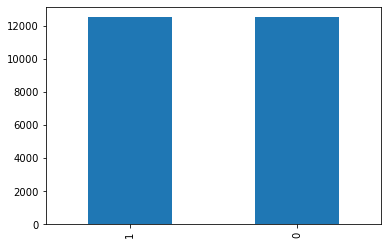

In [66]:
#equal amount of images for cats and dogs. 12500 images per category

df['category'].value_counts().plot.bar()

### See a random image

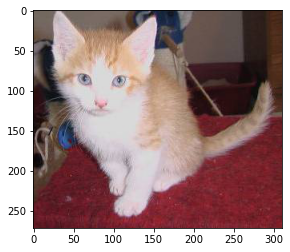

In [89]:
sample = random.choice(filenames)
image = load_img(r'C:\Users\Personal\Desktop\cats&dogs\train/'+sample)
plt.imshow(image)

In [102]:
 #Convert 0 and 1 into string values of cat and dog 

df['category'] = df['category'].replace({0:'cat', 1:'dog'})

### Train Test split

In [103]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

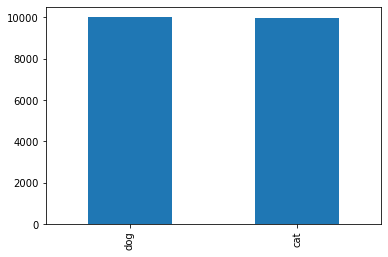

In [104]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

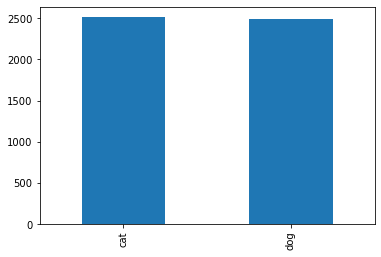

In [110]:
validate_df['category'].value_counts().plot.bar()

In [111]:
train_df.shape
validate_df.shape

(20000, 2)

(5000, 2)

### Training Genarator 

In [161]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
batch_size=15
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

**Train Generator**

In [147]:
train_datagen = ImageDataGenerator(rotation_range=15, rescale=1./255, horizontal_flip=True, shear_range=0.1,
                                                    zoom_range=0.2,width_shift_range=0.1,height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    r"C:\Users\Personal\Desktop\cats&dogs\train/", 
                                                    x_col= "filename",
                                                    y_col="category", 
                                                    target_size=IMAGE_SIZE,
                                                    class_mode="categorical", 
                                                    batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


**Test Generator**

In [148]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(validate_df, 
                                                            r"C:\Users\Personal\Desktop\cats&dogs\train/", 
                                                            x_col= "filename",
                                                            y_col="category", 
                                                            target_size=IMAGE_SIZE, 
                                                            class_mode="categorical", 
                                                            batch_size=batch_size)

Found 5000 validated image filenames belonging to 2 classes.


**See how the Generator works**

In [156]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_df

,filename,category
0,cat.10798.jpg,cat


In [157]:
example_generator = train_datagen.flow_from_dataframe(example_df, 
                                                        r"C:\Users\Personal\Desktop\cats&dogs\train/", 
                                                        x_col='filename',
                                                        y_col='category',
                                                        target_size=IMAGE_SIZE,
                                                        class_mode='categorical')

Found 1 validated image filenames belonging to 1 classes.


<Figure size 864x864 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

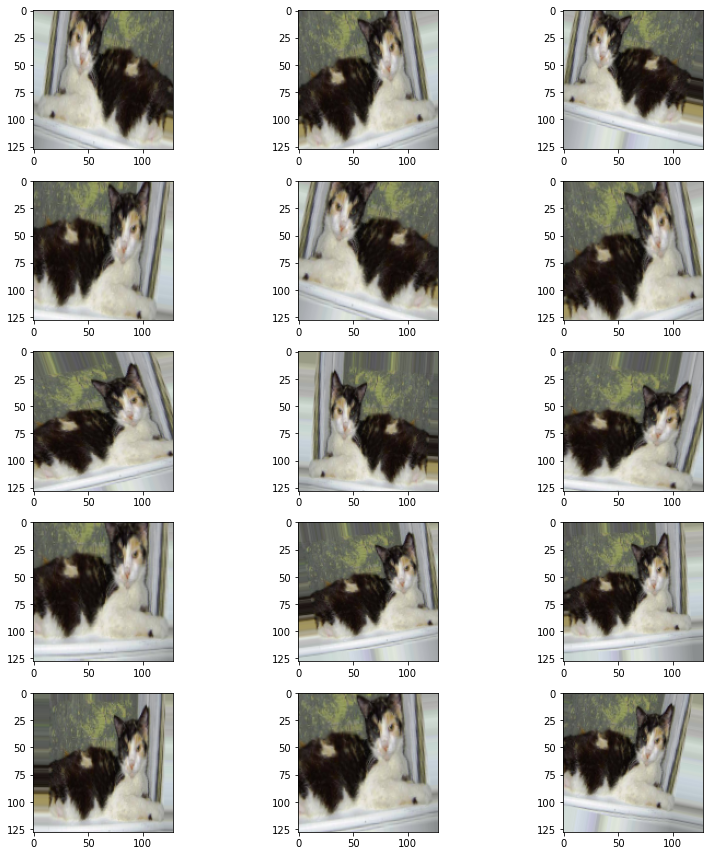

In [158]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Build the model

**Batch Normalization** Batch normalization is a technique designed to automatically standardize the inputs to a layer in a deep learning neural network. Once implemented, batch normalization has the effect of dramatically accelerating the training process of a neural network, and in some cases improves the performance of the model via a modest regularization effect.

In [162]:
# define new size and channel

FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
batch_size=15
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [178]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [94]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

### Early stop and Learnin rate reduction

In [179]:
#To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [98]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

## Fit the model

In [163]:
epochs=3 if FAST_RUN else 50

history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)


Epoch 1/50
1333/1333 [==============================] - 1411s 1s/step - loss: 0.7423 - accuracy: 0.6332 - val_loss: 0.6139 - val_accuracy: 0.7295
Epoch 2/50


C:\Users\Personal\anaconda3\envs\keras\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1333/1333 [==============================] - 1593s 1s/step - loss: 0.5454 - accuracy: 0.7309 - val_loss: 0.3403 - val_accuracy: 0.7984
Epoch 3/50
1333/1333 [==============================] - 1597s 1s/step - loss: 0.5011 - accuracy: 0.7625 - val_loss: 0.4852 - val_accuracy: 0.7537
Epoch 4/50
1333/1333 [==============================] - 1358s 1s/step - loss: 0.4625 - accuracy: 0.7858 - val_loss: 0.6880 - val_accuracy: 0.6461
Epoch 5/50
1333/1333 [==============================] - 1316s 987ms/step - loss: 0.4353 - accuracy: 0.8038 - val_loss: 0.5312 - val_accuracy: 0.7775
Epoch 6/50
1333/1333 [==============================] - 1401s 1s/step - loss: 0.4194 - accuracy: 0.8144 - val_loss: 0.3971 - val_accuracy: 0.8301
Epoch 7/50
1333/1333 [==============================] - 1433s 1s/step - loss: 0.3964 - accuracy: 0.8243 - val_loss: 0.5002 - val_accuracy: 0.8339
Epoch 8/50
1333/1333 [==============================] - 1741s 1s/step - loss: 0.3864 - accuracy: 0.8312 - val_loss: 0.7978 - val_acc

In [164]:
model.save("cats_vs_Dogs_Final.h5")

In [165]:
model.save_weights("cats_vs_Dogs_Final_weights.h5")

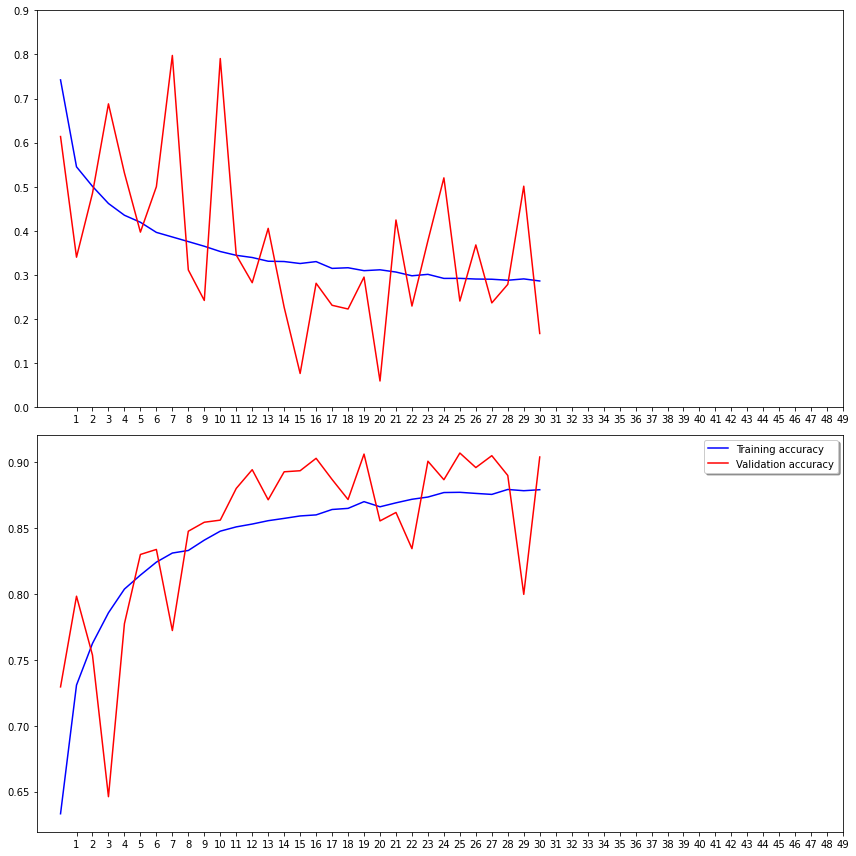

In [167]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Test on test images

In [194]:
test_filenames = os.listdir(r'C:\Users\Personal\Desktop\cats&dogs\test1')

test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

test_df.head()

,filename
0,1.jpg
1,10.jpg
2,100.jpg
3,1000.jpg
4,10000.jpg


In [196]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    r'C:\Users\Personal\Desktop\cats&dogs\test1', 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False)

Found 12500 validated image filenames.


In [197]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [198]:
test_df['category'] = np.argmax(predict, axis=-1)

In [199]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [200]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

,filename,category
0,1.jpg,1
1,10.jpg,0
2,100.jpg,0
3,1000.jpg,1
4,10000.jpg,1


<Figure size 864x1728 with 0 Axes>

<AxesSubplot:>

Text(0.5, 0, '1.jpg(1)')

<AxesSubplot:>

Text(0.5, 0, '10.jpg(0)')

<AxesSubplot:>

Text(0.5, 0, '100.jpg(0)')

<AxesSubplot:>

Text(0.5, 0, '1000.jpg(1)')

<AxesSubplot:>

Text(0.5, 0, '10000.jpg(1)')

<AxesSubplot:>

Text(0.5, 0, '10001.jpg(0)')

<AxesSubplot:>

Text(0.5, 0, '10002.jpg(0)')

<AxesSubplot:>

Text(0.5, 0, '10003.jpg(1)')

<AxesSubplot:>

Text(0.5, 0, '10004.jpg(1)')

<AxesSubplot:>

Text(0.5, 0, '10005.jpg(0)')

<AxesSubplot:>

Text(0.5, 0, '10006.jpg(0)')

<AxesSubplot:>

Text(0.5, 0, '10007.jpg(0)')

<AxesSubplot:>

Text(0.5, 0, '10008.jpg(0)')

<AxesSubplot:>

Text(0.5, 0, '10009.jpg(0)')

<AxesSubplot:>

Text(0.5, 0, '1001.jpg(0)')

<AxesSubplot:>

Text(0.5, 0, '10010.jpg(1)')

<AxesSubplot:>

Text(0.5, 0, '10011.jpg(1)')

<AxesSubplot:>

Text(0.5, 0, '10012.jpg(0)')

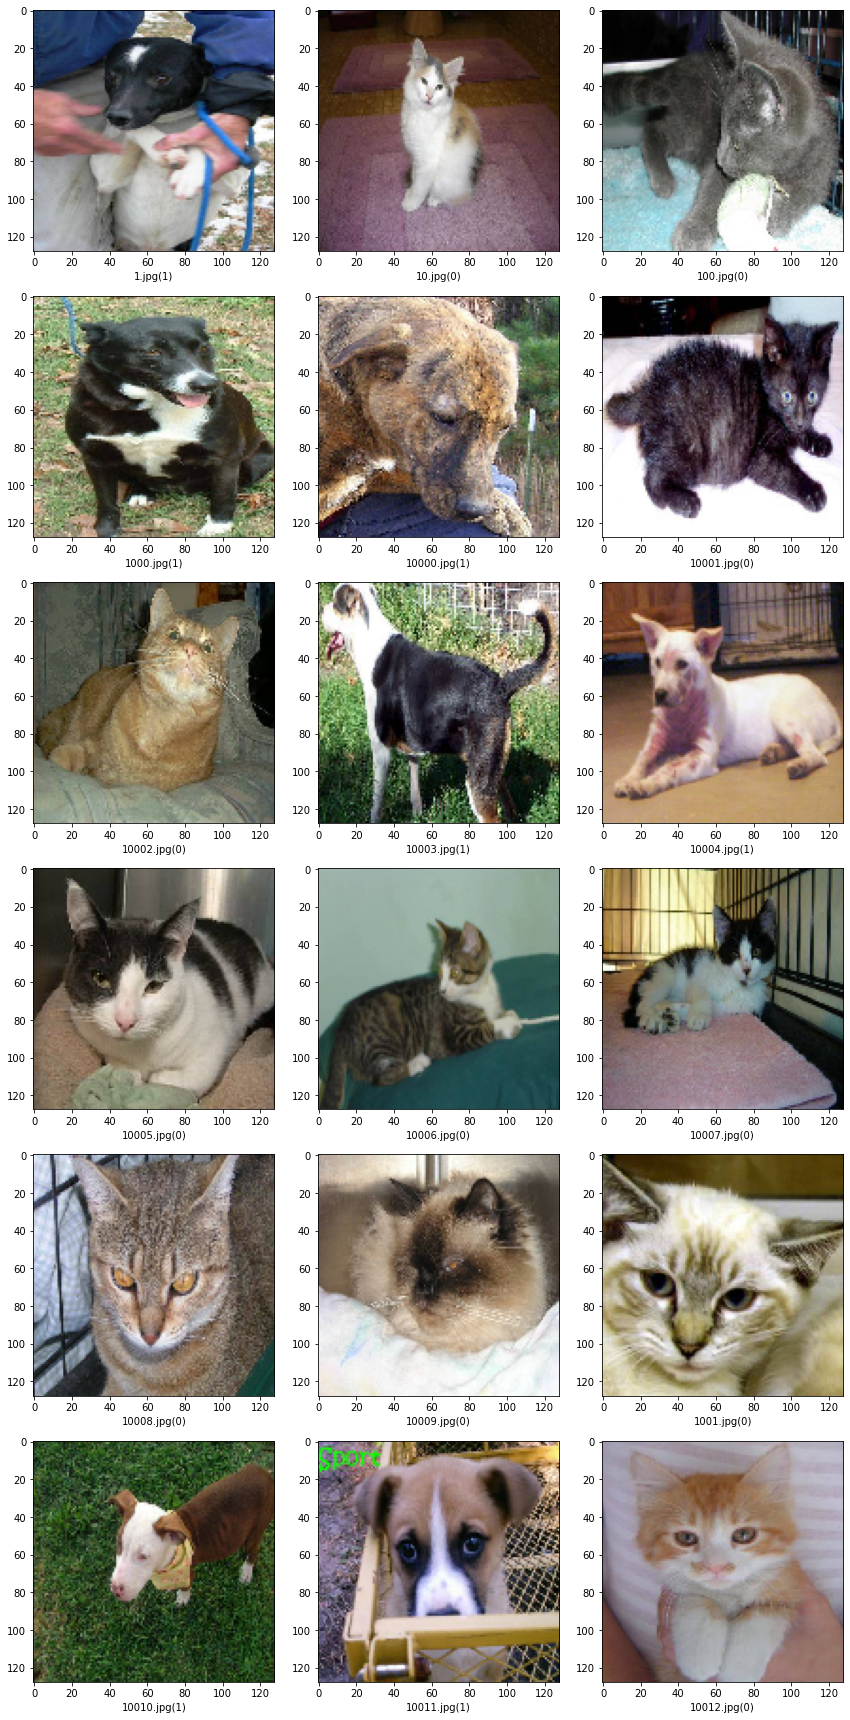

In [202]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(r"C:\Users\Personal\Desktop\cats&dogs\test1/" + filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()